In [1]:
import sys, os
import numpy as np
import pandas as pd
import xarray as xr
import glob as glob
from math import pi
import matplotlib as mpl

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from tqdm.notebook import trange, tqdm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy.signal import argrelmin, argrelmax, argrelextrema
from scipy import stats
from scipy.spatial import ConvexHull
from scipy.interpolate import griddata, RBFInterpolator

mpl.rcParams['mathtext.default'] = 'regular'

%matplotlib widget

# Functions for wafer simulation

In [2]:
# Define "sample" area and coordinates

# Create a shape
def simulate_2D_even(num_points, shape, width):
    if shape not in ['square', 'circle']:
        raise ValueError("shape must be either 'square' or 'circle'")

    side = int(np.sqrt(num_points)) # calculate number of points per side (assumes perfect square)
    x = np.linspace(-width/2, width/2, side)
    y = np.linspace(-width/2, width/2, side)
    xv, yv = np.meshgrid(x, y) # create grid coordinates from 1D x,y arrays. xv, yv are 2D arays for each point o nthe grid

    if shape == 'circle':
        mask = xv**2 + yv**2 <= (width/2)**2 # creates a circulal boolean mask where True is inside circle radius centered at origin
        xv = xv[mask] # filter outside radius
        yv = yv[mask]

    return np.column_stack([xv.ravel(), yv.ravel()]) # flatten 2D arrays to 1D, column stack to make 2D array of x,y coords

# Create dataset from coordinates (uses output from simulate_2D_even)
def create_dataset(coords, num_points, shape, width):
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]

    ds = xr.Dataset(
        coords={
            "x": ("points", x_coords),
            "y": ("points", y_coords),
            "xy": (("points", "tuple_index"), coords)
        }
    )

    ds.attrs['description'] = f"Simulated dataset with points = {num_points}, width = {width}, shape = {shape}."

    return ds
def calculate_equidistant_points(coords, num_sections, width, percent_dist_from_center, deg_rotation=-90, find_on_grid=True):
    radius = 0.5 * width # this is true for both square and circle
    center = (0,0) # assuming always centering at origin

    # Calculate angles in radians given a number of sections - endpoint = False ensures 0=360
    # deg_rotation allows for rotating the points to a desired position (e.g., set 1st point at bottom of shape)
    anglesrad = np.linspace(0, 2 * np.pi, num_sections, endpoint=False)
    anglesdeg = [np.degrees(angle) + deg_rotation for angle in anglesrad]
    angles = np.radians(anglesdeg)

    # Calculate the x and y coordinates
    x_coords = center[0] + (radius * percent_dist_from_center *0.01) * np.cos(angles)
    y_coords = center[1] + (radius * percent_dist_from_center * 0.01)  * np.sin(angles)

    # Find nearest coordinate for the x and y coords
    if find_on_grid is True:
        points = np.zeros((num_sections,2))
        for i, (x_coord, y_coord) in enumerate(zip(x_coords,y_coords)):
            distances = np.sqrt((coords[:,0] - x_coord)**2 + (coords[:,1] - y_coord)**2)
            nearest_index = int(distances.argmin())
            nearest_point = coords[nearest_index]
            points[i] = nearest_point
    else:
        points = np.column_stack((x_coords,y_coords))

    return points

def divide_shape_into_sections(num_sections, width, shape):
    angle_increment = 360 / num_sections
    half_width = width / 2
    centers = []

    for i in range(num_sections):
        angle_deg = angle_increment * i + angle_increment / 2 # angle of section center
        angle_rad = np.deg2rad(angle_deg)

        if shape == 'square':
            if angle_deg == 90 or angle_deg == 270:
                center_x = 0
                center_y = half_width if angle_deg == 90 else -half_width
            else:
                slope = np.tan(angle_rad)
                if abs(slope) <= 1:
                    center_x = half_width if np.cos(angle_rad) > 0 else -half_width
                    center_y = center_x * slope
                else:
                    center_y = half_width if np.sin(angle_rad) > 0 else -half_width
                    center_x = center_y / slope
        elif shape == 'circle':
            radius = half_width
            center_x = radius * np.cos(angle_rad)
            center_y = radius * np.sin(angle_rad)
        else:
            raise ValueError("shape must be either 'square' or 'circle'")

        centers.append((center_x / 2, center_y / 2))

    return np.array(centers)

def calculate_composition_weights(ds, elements, composition_centers, composition_at_centers, smoothing_factor=1.0):
    x_coords = ds['x'].values
    y_coords = ds['y'].values
    coords = np.column_stack((x_coords, y_coords))

    # Number of points and elements
    num_points = coords.shape[0]
    num_elements = composition_at_centers.shape[1]
    if num_elements != len(elements):
        raise ValueError(f"length of elements is {len(elements)}, but composition_at_centers.shape[1] is {num_elements}. These must be the same")

    # Initialize weights array
    weights = np.zeros((num_points, num_elements))

    # Track points that match composition centers
    fixed_points = np.zeros(num_points, dtype=bool)

    # Identify matching points
    for i, (x_center, y_center) in enumerate(composition_centers):
        matching_points = (coords[:, 0] == x_center) & (coords[:, 1] == y_center)
        weights[matching_points] = composition_at_centers[i]
        fixed_points |= matching_points

    # Calculate weights for non-fixed points
    for i, (x_center, y_center) in enumerate(composition_centers):
        # Calculate distances
        distances = np.sqrt((coords[:, 0] - x_center) ** 2 + (coords[:, 1] - y_center) ** 2)

        # Apply Gaussian smoothing and reshape
        exp_distances = np.exp(-distances / smoothing_factor)  # shape = num_points
        exp_distances_reshaped = exp_distances.reshape(-1, 1)  # shape = num_points, 1

        # Multiply distances with composition_at_centers[i] for non-fixed points
        weighted_composition_at_center = exp_distances_reshaped * composition_at_centers[i]  # shape = num_points, num_elements

        # Add weighted composition to weights for non-fixed points
        weights[~fixed_points] += weighted_composition_at_center[~fixed_points]

    # Normalize weights to sum to 1 for each point
    weights_sum = weights.sum(axis=1)  # shape = num_points
    weights_normalized = weights / weights_sum[:, np.newaxis]
    weights = weights_normalized

    # Precision issue with weights is annoying for interpolation, so if sum of weights for a row is within 1e-8, divide difference by N elements and subtract/add
    weight_tolerance = 1e-20

    for index, weight in enumerate(weights):
        weight_sum = np.sum(weight)
        if not np.isclose(weight_sum, 1.0, atol=weight_tolerance):
            weight_diff = 1 - weight_sum
            if np.abs(weight_diff) < weight_tolerance:
                if weight_diff > 0:  # weight sum less than 1
                    weights[index, 0] += weight_diff
                else:  # weight sum greater than 1
                    weights[index, 0] -= weight_diff
            else:
                raise ValueError(f'Summed weight for index {index} outside tolerance for adjustment - inspect calculation of weights')

    # Check if all rows sum to 1 within tolerance
    counter = 0
    for index, weight in enumerate(weights):
        if not np.isclose(np.sum(weight), 1.0, atol=weight_tolerance):
            print(index, np.sum(weight), weight)
            counter += 1
    if counter != 0:
        raise ValueError(f"Number of weights (rows) not summing to 1: {counter}")


    # Assign coordinates and weights to the dataset
    repeated_elements = np.tile(elements, (num_points, 1))

    ds = ds.assign_coords(
        elements=(("points", "elements"), repeated_elements),
        element_weights=(("points", "weights"), weights)
    )
    composition_at_centers_str = [str(comp) for comp in composition_at_centers]
    composition_centers_str = [str(pos) for pos in composition_centers]
    ds.attrs['composition_centers (coords)'] = composition_centers_str
    ds.attrs['composition_centers (weights)'] = composition_at_centers_str
    ds.attrs['smoothing_factor'] = smoothing_factor

    return ds


def get_element_weights_at_coordinates(x_coord, y_coord, dataset, method='interpolate'):
    elements = np.array(dataset['elements'][0].values) # all elements are equivalent
    if method == 'nearest':
        distances = np.sqrt((dataset['x'] - x_coord)**2 + (dataset['y'] - y_coord)**2)
        nearest_index = int(distances.argmin())
        nearest_weight = dataset['element_weights'][nearest_index].values
        return dict(zip(elements, nearest_weight))
    elif method == 'interpolate':
        if is_inside_convex_hull(x_coord, y_coord, dataset['xy'].values) is True:
            #print('xy position inside, interpolating')
            interpolated_weight = griddata(points=(dataset['x'].values, dataset['y'].values),
                                          values=dataset['element_weights'].values,
                                          xi=(x_coord, y_coord),
                                          method='linear')
            return dict(zip(elements, interpolated_weight))
        else:
            raise ValueError('xy position outside bounds - enter coordinates within bounds')
    else:
        raise NameError(f"method not recognized - must be 'nearest' or 'interpolate' and input was {method}")

In [3]:
# Interpolation methods
def interpolate_phase_weights(element_weights_wafer, element_weights_PD, phase_weights_PD):
    # Initialize phase_weights_wafer with NaNs
    phase_weights_wafer = np.full((element_weights_wafer.shape[0], phase_weights_PD.shape[1]), np.nan)

    # Perform the interpolation for each dimension of the phase weights
    for i in range(phase_weights_PD.shape[1]):
        rbf_interpolator = RBFInterpolator(element_weights_PD, phase_weights_PD[:, i], kernel='linear')
        interpolated_values = rbf_interpolator(element_weights_wafer)

        # Ensure non-negative values
        interpolated_values = np.clip(interpolated_values, 0, np.inf)

        phase_weights_wafer[:, i] = interpolated_values

    # Normalize the rows to sum to 1.0
    row_sums = np.sum(phase_weights_wafer, axis=1, keepdims=True)
    # Avoid division by zero by setting row_sums to 1 where it's 0
    row_sums[row_sums == 0] = 1
    phase_weights_wafer = phase_weights_wafer / row_sums

    return phase_weights_wafer

def interpolate_iq_wafer(phase_weights_wafer, phase_weights_PD, iq_PD_ionly, epsilon=1e-10):
    # Initialize iq_wafer_ionly with NaNs
    iq_wafer_ionly = np.full((phase_weights_wafer.shape[0], iq_PD_ionly.shape[1]), np.nan)

    # Perform the interpolation for each dimension of the phase weights
    for i in range(iq_PD_ionly.shape[1]):
        try:
            # Add a small perturbation to phase_weights_PD to avoid singular matrix issues
            phase_weights_PD_perturbed = phase_weights_PD + epsilon * np.random.randn(*phase_weights_PD.shape)

            rbf_interpolator = RBFInterpolator(phase_weights_PD_perturbed, iq_PD_ionly[:, i], kernel='linear')
            interpolated_values = rbf_interpolator(phase_weights_wafer)

            # Ensure non-negative values
            #interpolated_values = np.clip(interpolated_values, 0, np.inf)

            iq_wafer_ionly[:, i] = interpolated_values
        except Exception as e:
            print(f"Error interpolating dimension {i}: {e}")

    # Normalize the rows to sum to 1.0
    #row_sums = np.sum(iq_wafer_ionly, axis=1, keepdims=True)
    # Avoid division by zero by setting row_sums to 1 where it's 0
    #row_sums[row_sums == 0] = 1
    #iq_wafer_ionly = iq_wafer_ionly / row_sums

    return iq_wafer_ionly

def interpolate_and_addtods(ds, ds_DRNets):

    # Get arrays from ds and ds_DRNets
    element_weights_wafer = ds['element_weights'].values  # shape (709, 3)
    element_weights_PD = ds_DRNets['element_weights'].values  # shape (231, 3)

    phase_weights_PD = ds_DRNets['phase_weights'].values  # shape (231, 6)

    iq_PD = ds_DRNets['iq'].values
    iq_PD_ionly = iq_PD[:, 1, :] # only grabbing the intensity array, shape (231, 650)
    q_points = iq_PD[0][0]

    phase_weights_wafer = interpolate_phase_weights(element_weights_wafer, element_weights_PD, phase_weights_PD)
    iq_wafer_ionly = interpolate_iq_wafer(phase_weights_wafer, phase_weights_PD, iq_PD_ionly)

    iq_wafer = np.empty((iq_wafer_ionly.shape[0], 2, len(q_points)))

    # Fill the first slice of the second axis with q_points
    iq_wafer[:, 0, :] = q_points

    # Fill the second slice of the second axis with iq_wafer_ionly
    iq_wafer[:, 1, :] = iq_wafer_ionly

    # Get phase names, tile to ds shape
    phase_names = ds_DRNets['phase_names'][0].values
    repeated_names = np.tile(phase_names, (phase_weights_wafer.shape[0], 1))

    ds = ds.assign_coords(
        phase_names=(("points", "names"), repeated_names),
    )

    # Add phase_weights, I(Q) to ds
    ds['phase_weights'] = (('points', 'phase_weights'), phase_weights_wafer)
    ds['iq'] = (('points', 'tuple_index', 'q_points'), iq_wafer)

    return ds

In [4]:
def plot_ground_truth(ds, weight_rounding=8, weight_cutoff=0.00001, colormap = 'Set2', marker='s',marker_size=20):
    x_array = np.array(ds.x)
    y_array = np.array(ds.y)
    phase_weights = np.array(ds.phase_weights)
    phase_names = np.array(ds.phase_names)

    # Generate phase_names_short array
    phase_names_short = []
    for names in phase_names:
        #print(names)
        phase_names_list = []
        for name in names:
            short_name = str(name).split('+')[1].split('_')[0]
            phase_names_list.append(short_name)
        phase_names_short.append(phase_names_list)

    phase_names_short = np.array(phase_names_short)

    # Generate phase_weights_rd array
    phase_weights_rd = []
    for weights in phase_weights:
        phase_weights_list = []
        for weight in weights:
            weight_rd = round(weight,weight_rounding)
            phase_weights_list.append(weight_rd)
        phase_weights_rd.append(phase_weights_list)
    phase_weights_rd = np.array(phase_weights_rd)

    phases_present = []
    for weights, names in zip(phase_weights_rd, phase_names_short):
        phases_present_list = []
        for weight, name in zip(weights,names):
            if weight > weight_cutoff:
                phases_present_list.append(name)
        phases_present.append(phases_present_list)

    unique_sublists = set(tuple(sublist) for sublist in phases_present)

    # The number of unique sublists
    num_unique_sublists = len(unique_sublists)

    #print(f"The number of unique sublists is: {num_unique_sublists}")

        # Convert sublists to tuples
    phases_present_tuples = [tuple(sublist) for sublist in phases_present]

    # Create a dictionary mapping each unique sublist to a unique integer key
    unique_sublists = set(phases_present_tuples)
    sublist_to_key = {sublist: key for key, sublist in enumerate(unique_sublists)}

    # Create a list of keys corresponding to each sublist in phases_present
    keys_array = np.array([sublist_to_key[sublist] for sublist in phases_present_tuples])

    # Define a discrete colormap with a fixed number of distinct colors
    num_keys = len(unique_sublists)
    colors = plt.colormaps[colormap](range(num_keys))  # Use the recommended approach for colormap

    # Create the ListedColormap
    cmap = ListedColormap(colors)

    # Plot the data
    plt.figure(figsize=(10,6))
    scatter = plt.scatter(x_array, y_array, c=keys_array, cmap=cmap, marker=marker, s=marker_size)

    # Create the custom legend
    legend_elements = []
    for sublist, key in sublist_to_key.items():
        color = cmap(key)
        label = ', '.join(sublist)
        legend_elements.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10, label=label))

    # Add the legend outside the plot
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1), loc='upper left')
    plt.tight_layout()

# Simulating an Al-Li-Fe wafer

Important to remember:
- Step 5 is where the phase diagram dataset must be called as input to interpolate_and_addtods()
- If not an object available in memory, load dataset (.nc filetype)

Steps:
1) Make coordinates
    - Input num_points, shape (circle/sqaure), width (diameter)
2) Set composition_centers w/ elemental composition
    - Order of items (elements) in elements corresponds to order in composition arrays
    - Can calculate equidistant points around shape with distance scaled from center to edge
3) Create Xarray dataset from coords, num_points, shape, and width
4) Calculate elemental weights (composition_weights) based on:
    - composition at discrete points (composition_at_centers)
    - position of discrete points (composition_centers)
    - smoothing factor (distance weighted smoothing)
5) Interpolate phase weights, I(Q) from ds_DRNets (phase diagram encapsulated in a dataset), add to wafer dataset
    - Phase weights are interpolated from element_weights (on wafer) and element_weights + phase_weights (on phase diagram)
    - I(Q) are interpolated from phase_weights (on wafer) and phase_weights + I(Q) (on phase diagram)
6) Save wafer dataaset as netCDF file type (structure and data types preserved)
7) Plot "ground truth" map of phases present on wafer

In [5]:
# Step 0: load phase diagram datasets (loading all 3 in case all are used)
path = '/nsls2/users/acorrao/MMM/DataSimulator/ForPhil/phasediagram_datasets'
file = 'Al-Li-Fe_dataset.nc'
ds_AlLiFe = xr.open_dataset(os.path.join(path,file))
os.chdir(path) # moving into dir so that any files generated default to this dir

path = '/nsls2/users/acorrao/MMM/DataSimulator/ForPhil/phasediagram_datasets'
file = 'Bi-Cu-V_dataset.nc'
ds_BiCuV = xr.open_dataset(os.path.join(path,file))
os.chdir(path) # moving into dir so that any files generated default to this dir

path = '/nsls2/users/acorrao/MMM/DataSimulator/ForPhil/phasediagram_datasets'
file = 'Li-Sr-Al_dataset.nc'
ds_LiSrAl = xr.open_dataset(os.path.join(path,file))
os.chdir(path) # moving into dir so that any files generated default to this dir

[[ 0. -5.]
 [ 5.  0.]
 [ 0.  5.]
 [-5.  0.]]


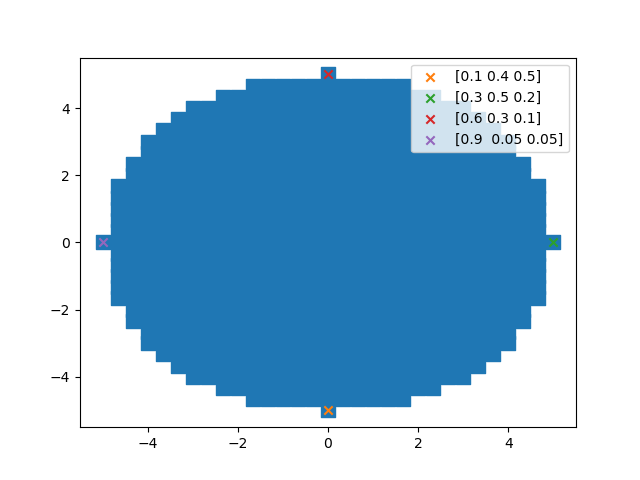

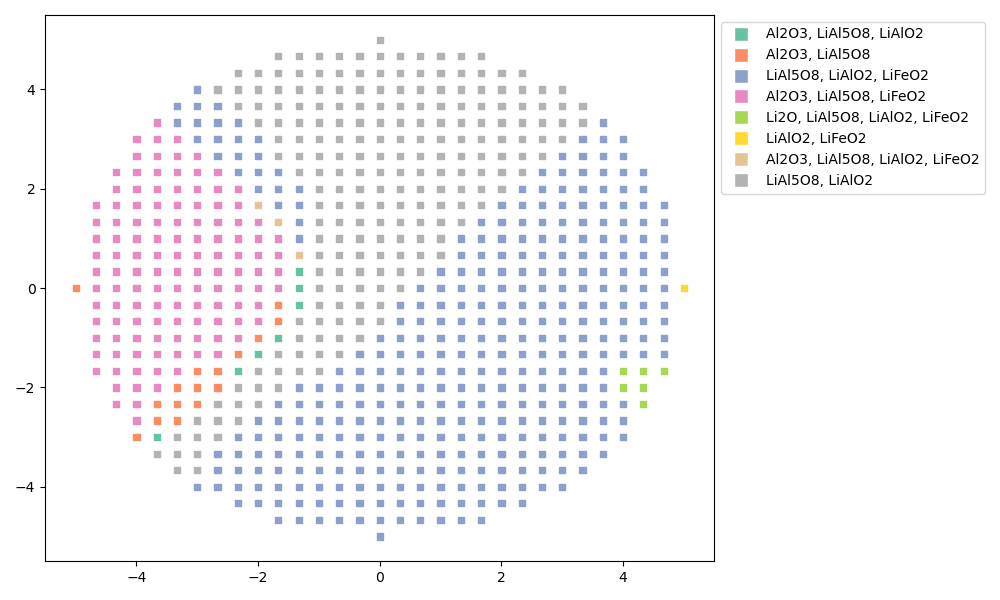

In [6]:
# 1) Make coords
num_points = 1000  # Example number of points
shape = 'circle'  # Can be 'square' or 'circle'
width = 10  # Width of the square or diameter of the circle
coords = simulate_2D_even(num_points, shape, width)

# 2) Set composition_centers w/ composition - drawing boundaries may be a relevant part of this
# - Then each composition center should have corresponding_coords which is an array of x,y coords belonging to the section
elements = ['Al','Li','Fe']
num_compositions = 4
composition_at_centers = np.array([
    np.array([0.1, 0.4, 0.5]),  # composition 1
    np.array([0.3, 0.5, 0.2]),  # composition 2
    np.array([0.6, 0.3, 0.1]),  # composition 3
    np.array([0.9, 0.05, 0.05])  # composition 4
])

if len(composition_at_centers) != num_compositions:
    raise ValueError(f'lengh of composition_at_centers must match num_compositions')

# Calculating composition centers (alternatively can define manually) - POINTS MUST FALL ON GRID OTHERWISE WILL INTERPOLATE (which is fine)
composition_centers = calculate_equidistant_points(coords, num_compositions, width, percent_dist_from_center=100, deg_rotation=-90)
print(composition_centers)

# 3) Create dataset
ds = create_dataset(coords, num_points, shape, width)

#Sanity check for relative position of each concentration center and calculated vs. nearest (from equidistant point calc)
plt.figure()
plt.scatter(coords[:,0],coords[:,1], marker='s', s=100)
for comp, (x,y) in zip(composition_at_centers,composition_centers):
    plt.scatter(x,y,label=comp, marker='x')
plt.legend()


# 4) Calculate composition weights (composition version of calculate_phase_weights)
# Includes smoothing factor for the composition weights (element weights)
ds = calculate_composition_weights(ds, elements, composition_centers, composition_at_centers, smoothing_factor=1.0)

# 5) Interpolate phase weights, I(Q) from ds_DRNets, add to ds

ds = interpolate_and_addtods(ds, ds_AlLiFe)

# 6) Save ds
path = '/nsls2/users/acorrao/MMM/DataSimulator'
file = f'ds_AlLiFe_{len(ds.x)}-points.nc'
ds.to_netcdf(os.path.join(path, file))

# 7) Plot ground truth
plot_ground_truth(ds, weight_rounding=8, weight_cutoff=0.00001, colormap = 'Set2', marker='s',marker_size=20)

# Wafer 2: This Time It's Fine

[[ 0.05050505 -4.8989899 ]
 [ 4.8989899  -0.05050505]
 [ 0.05050505  4.8989899 ]
 [-4.8989899   0.05050505]]


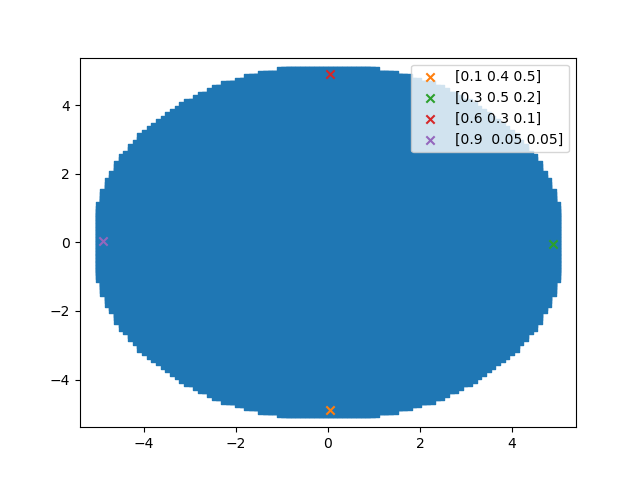

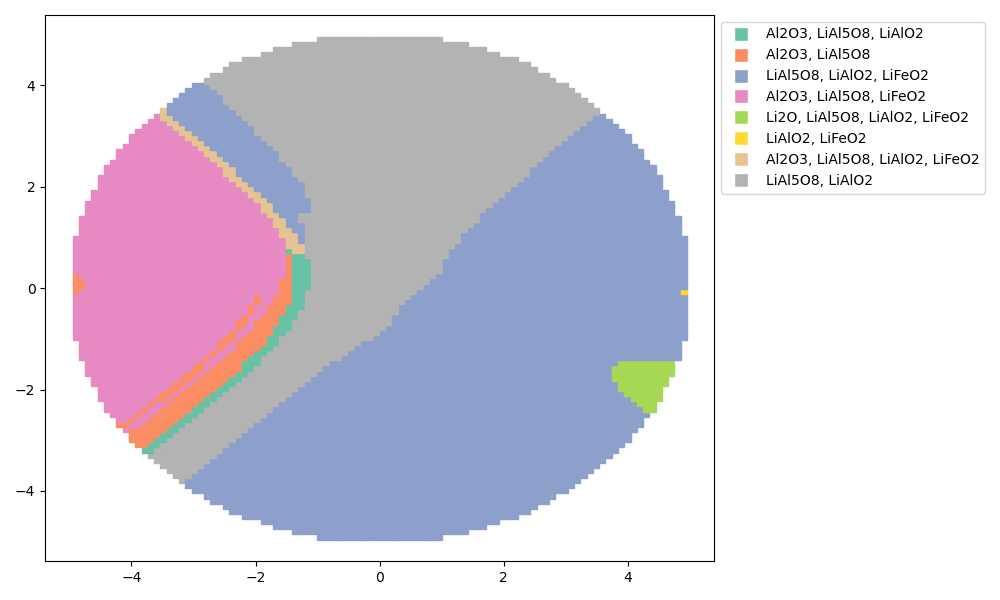

In [7]:
# 1) Make coords
num_points = 10000  # Example number of points
shape = 'circle'  # Can be 'square' or 'circle'
width = 10  # Width of the square or diameter of the circle
coords = simulate_2D_even(num_points, shape, width)

# 2) Set composition_centers w/ composition - drawing boundaries may be a relevant part of this
# - Then each composition center should have corresponding_coords which is an array of x,y coords belonging to the section
elements = ['Al','Li','Fe']
num_compositions = 4
composition_at_centers = np.array([
    np.array([0.1, 0.4, 0.5]),  # composition 1
    np.array([0.3, 0.5, 0.2]),  # composition 2
    np.array([0.6, 0.3, 0.1]),  # composition 3
    np.array([0.9, 0.05, 0.05])  # composition 4
])

if len(composition_at_centers) != num_compositions:
    raise ValueError(f'lengh of composition_at_centers must match num_compositions')

# Calculating composition centers (alternatively can define manually) - POINTS MUST FALL ON GRID OTHERWISE WILL INTERPOLATE (which is fine)
composition_centers = calculate_equidistant_points(coords, num_compositions, width, percent_dist_from_center=100, deg_rotation=-90)
print(composition_centers)
# 3) Create dataset
ds = create_dataset(coords, num_points, shape, width)

#Sanity check for relative position of each concentration center and calculated vs. nearest (from equidistant point calc)
plt.figure()
plt.scatter(coords[:,0],coords[:,1], marker='s', s=100)
for comp, (x,y) in zip(composition_at_centers,composition_centers):
    plt.scatter(x,y,label=comp, marker='x')
plt.legend()


# 4) Calculate composition weights (composition version of calculate_phase_weights)
# Includes smoothing factor for the composition weights (element weights)
ds = calculate_composition_weights(ds, elements, composition_centers, composition_at_centers, smoothing_factor=1.0)

# 5) Interpolate phase weights, I(Q) from ds_DRNets, add to ds

ds = interpolate_and_addtods(ds, ds_AlLiFe)

# 6) Save ds
path = '/nsls2/users/acorrao/MMM/DataSimulator'
file = f'ds_AlLiFe_{len(ds.x)}-points.nc'
ds.to_netcdf(os.path.join(path, file))

# 7) Plot ground truth
plot_ground_truth(ds, weight_rounding=8, weight_cutoff=0.00001, colormap = 'Set2', marker='s',marker_size=20)

## Wafer phase weight maps

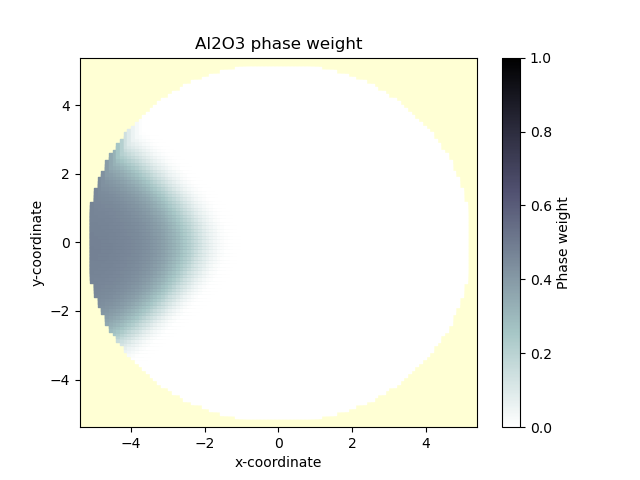

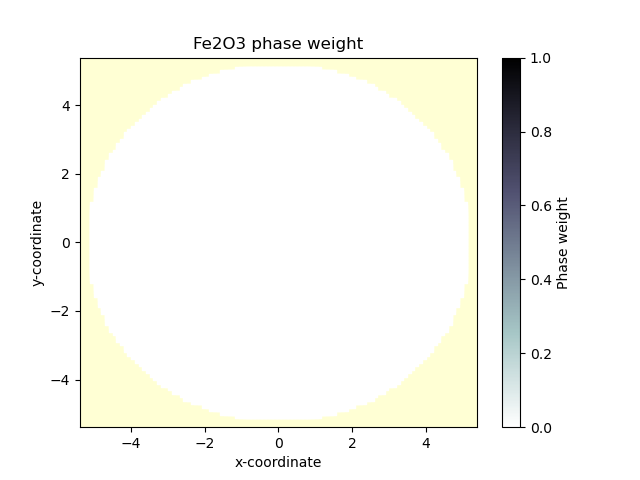

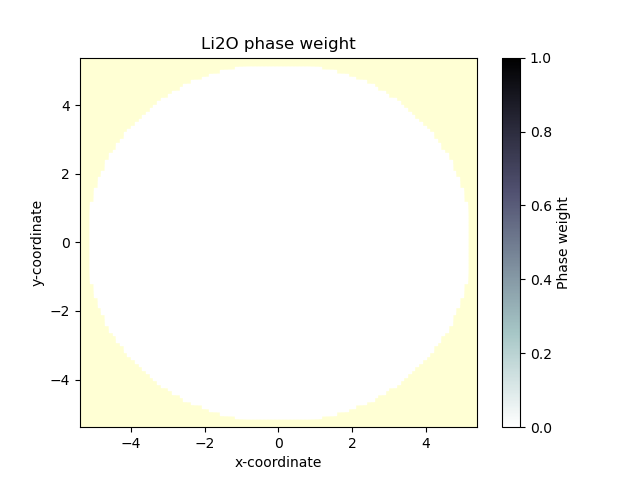

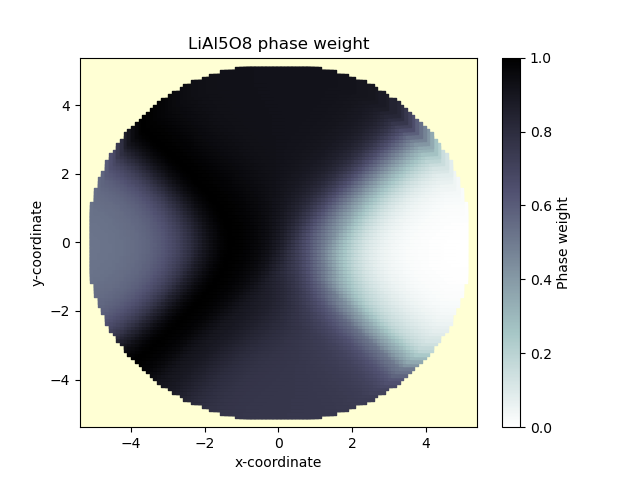

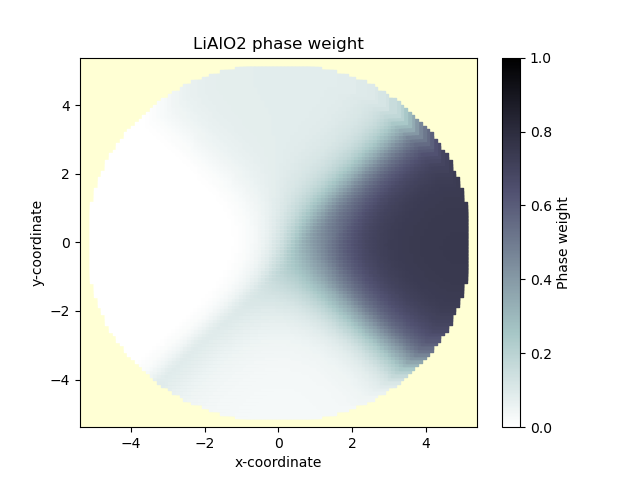

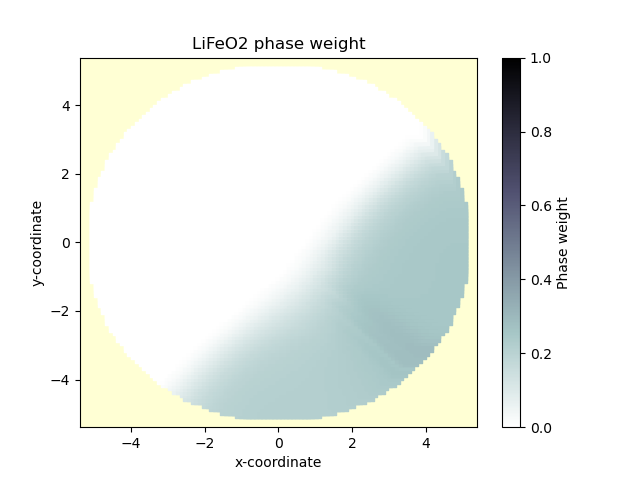

In [8]:
x_array = np.array(ds.x)
y_array = np.array(ds.y)
phase_weights = np.array(ds.phase_weights)
phase_names = np.array(ds.phase_names)

marker = 's'
marker_size = 125
for i in range(phase_weights.shape[1]):
    plt.figure()
    ax = plt.axes()
    ax.set_facecolor("xkcd:eggshell")
    plt.scatter(x_array, y_array, c=phase_weights[:,i], cmap='bone_r', marker=marker, s=marker_size, vmin=0, vmax=1)
    plt.title(f"{phase_names[0][i].split('+')[1].split('_')[0]} phase weight")
    plt.colorbar(label='Phase weight')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')



## Wafer element weight maps

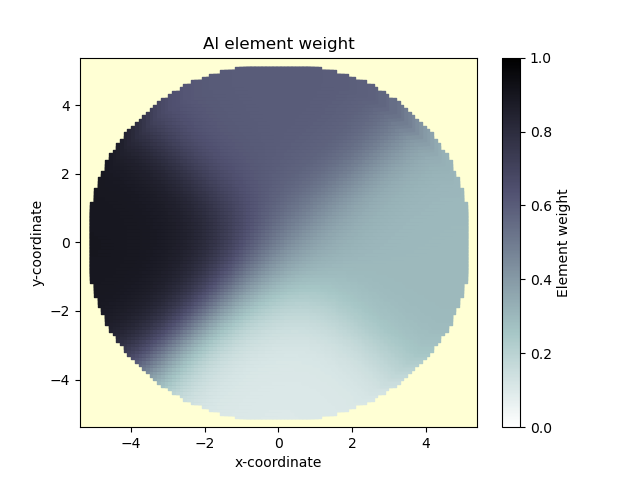

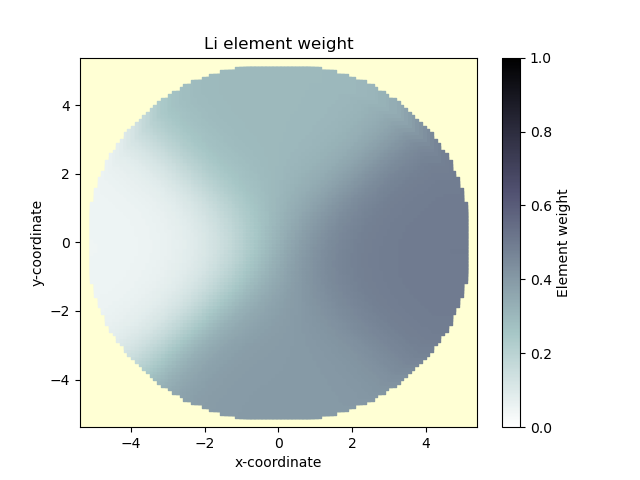

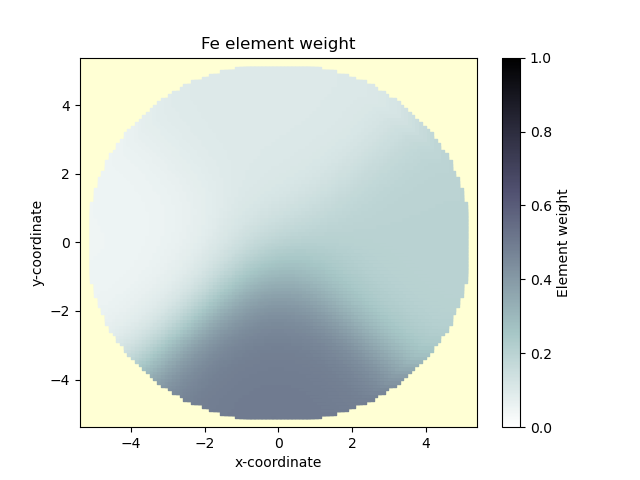

In [9]:
x_array = np.array(ds.x)
y_array = np.array(ds.y)
element_weights = np.array(ds.element_weights)
element_names = np.array(ds.elements)

marker = 's'
marker_size = 125
for i in range(element_weights.shape[1]):
    plt.figure()
    ax = plt.axes()
    ax.set_facecolor("xkcd:eggshell")
    plt.scatter(x_array, y_array, c=element_weights[:,i], cmap='bone_r', marker=marker, s=marker_size, vmin=0, vmax=1)
    plt.title(f"{element_names[0][i]} element weight")
    plt.colorbar(label='Element weight')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')



# Wafer 3: 10^5 points

## Wafer creation + ground truth phase map

[[ 0.01587302 -4.96825397]
 [ 4.96825397 -0.01587302]
 [ 0.01587302  4.96825397]
 [-4.96825397  0.01587302]]


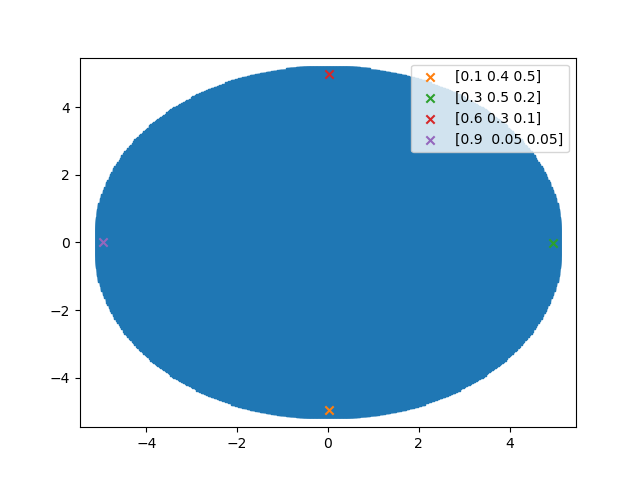

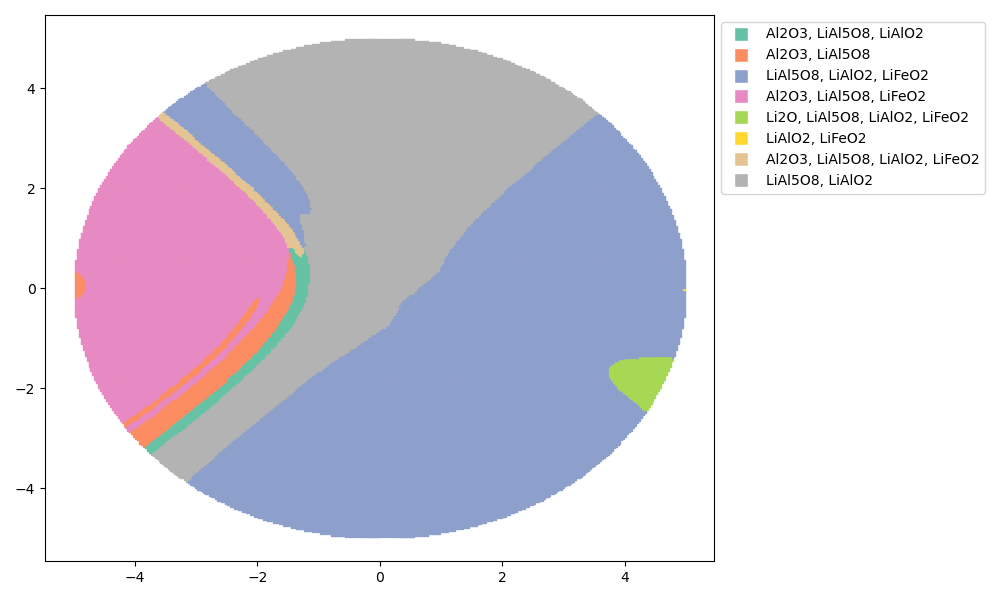

In [20]:
# 1) Make coords
num_points = 100000  # Example number of points
shape = 'circle'  # Can be 'square' or 'circle'
width = 10  # Width of the square or diameter of the circle
coords = simulate_2D_even(num_points, shape, width)

# 2) Set composition_centers w/ composition - drawing boundaries may be a relevant part of this
# - Then each composition center should have corresponding_coords which is an array of x,y coords belonging to the section
elements = ['Al','Li','Fe']
num_compositions = 4
composition_at_centers = np.array([
    np.array([0.1, 0.4, 0.5]),  # composition 1
    np.array([0.3, 0.5, 0.2]),  # composition 2
    np.array([0.6, 0.3, 0.1]),  # composition 3
    np.array([0.9, 0.05, 0.05])  # composition 4
])

if len(composition_at_centers) != num_compositions:
    raise ValueError(f'lengh of composition_at_centers must match num_compositions')

# Calculating composition centers (alternatively can define manually) - POINTS MUST FALL ON GRID OTHERWISE WILL INTERPOLATE (which is fine)
composition_centers = calculate_equidistant_points(coords, num_compositions, width, percent_dist_from_center=100, deg_rotation=-90)
print(composition_centers)
# 3) Create dataset
ds = create_dataset(coords, num_points, shape, width)

#Sanity check for relative position of each concentration center and calculated vs. nearest (from equidistant point calc)
plt.figure()
plt.scatter(coords[:,0],coords[:,1], marker='s', s=100)
for comp, (x,y) in zip(composition_at_centers,composition_centers):
    plt.scatter(x,y,label=comp, marker='x')
plt.legend()


# 4) Calculate composition weights (composition version of calculate_phase_weights)
# Includes smoothing factor for the composition weights (element weights)
ds = calculate_composition_weights(ds, elements, composition_centers, composition_at_centers, smoothing_factor=1.0)

# 5) Interpolate phase weights, I(Q) from ds_DRNets, add to ds

ds = interpolate_and_addtods(ds, ds_AlLiFe)

# 6) Save ds
path = '/nsls2/users/acorrao/MMM/DataSimulator'
file = f'ds_AlLiFe_{len(ds.x)}-points.nc'
ds.to_netcdf(os.path.join(path, file))

# 7) Plot ground truth
plot_ground_truth(ds, weight_rounding=8, weight_cutoff=0.00001, colormap = 'Set2', marker='s',marker_size=1)

## Phase weights map

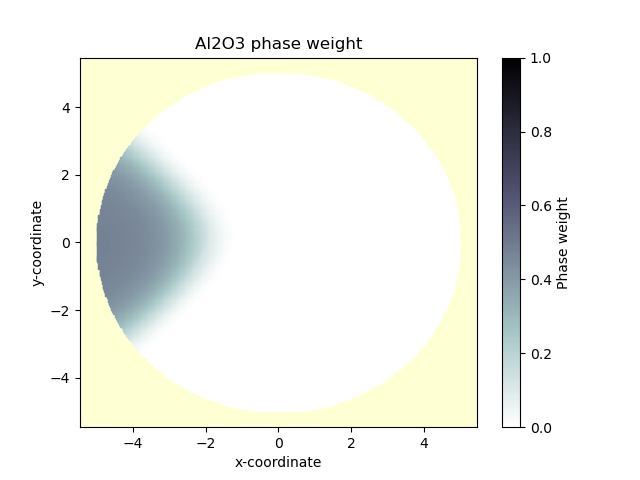

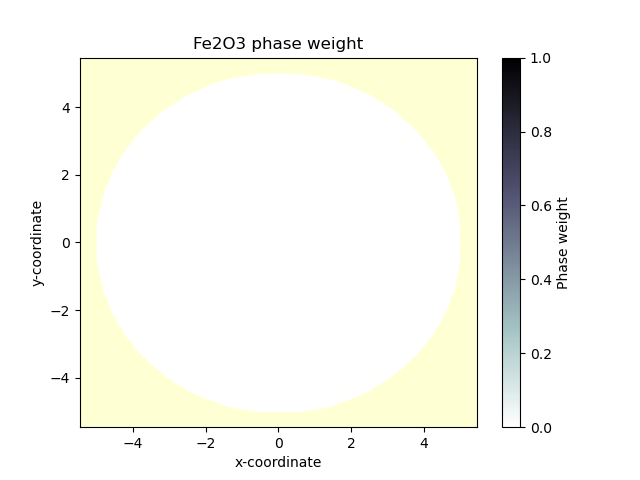

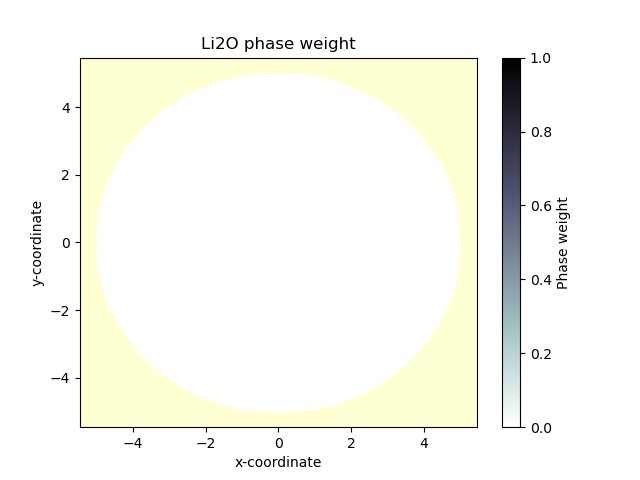

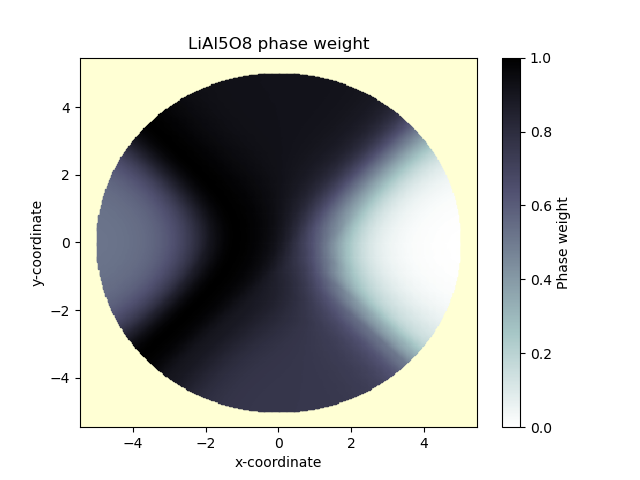

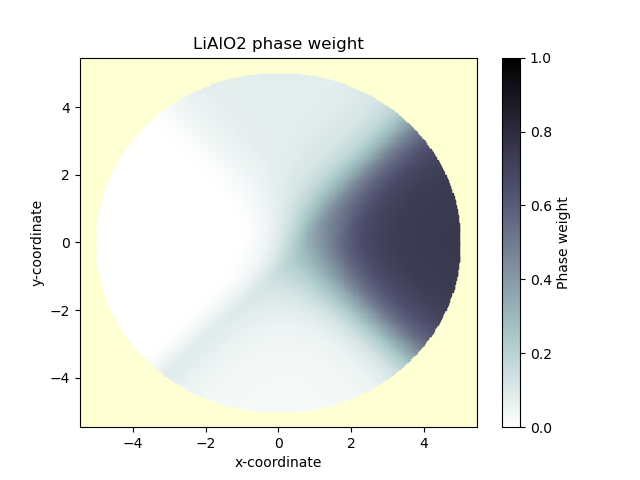

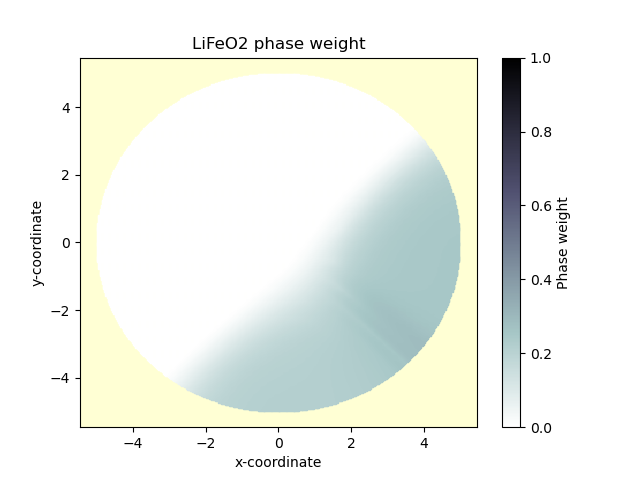

In [21]:
x_array = np.array(ds.x)
y_array = np.array(ds.y)
phase_weights = np.array(ds.phase_weights)
phase_names = np.array(ds.phase_names)

marker = 's'
marker_size = 1
for i in range(phase_weights.shape[1]):
    plt.figure()
    ax = plt.axes()
    ax.set_facecolor("xkcd:eggshell")
    plt.scatter(x_array, y_array, c=phase_weights[:,i], cmap='bone_r', marker=marker, s=marker_size, vmin=0, vmax=1)
    plt.title(f"{phase_names[0][i].split('+')[1].split('_')[0]} phase weight")
    plt.colorbar(label='Phase weight')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')



## Element weights map

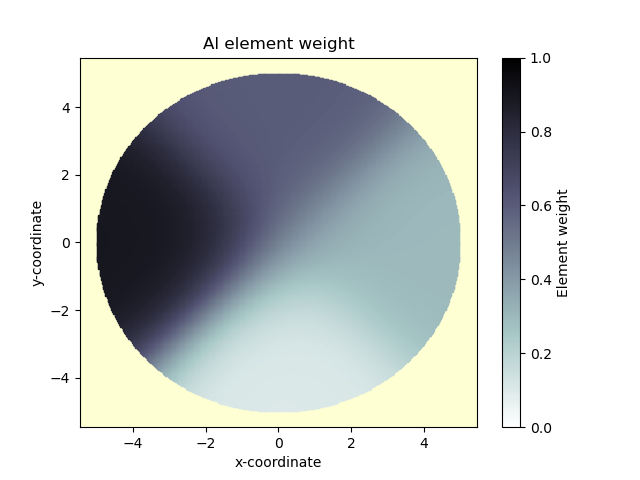

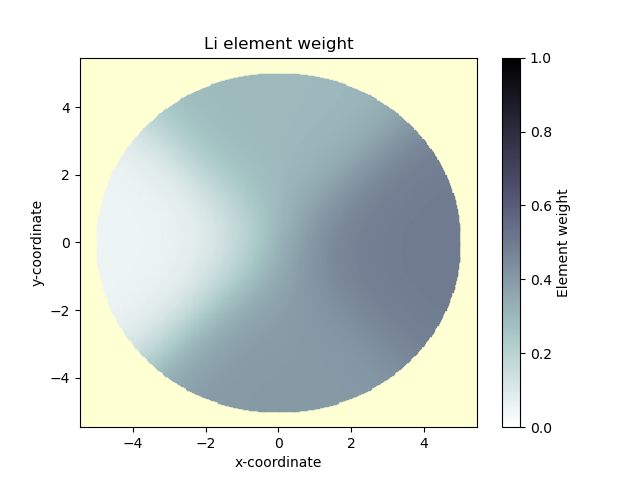

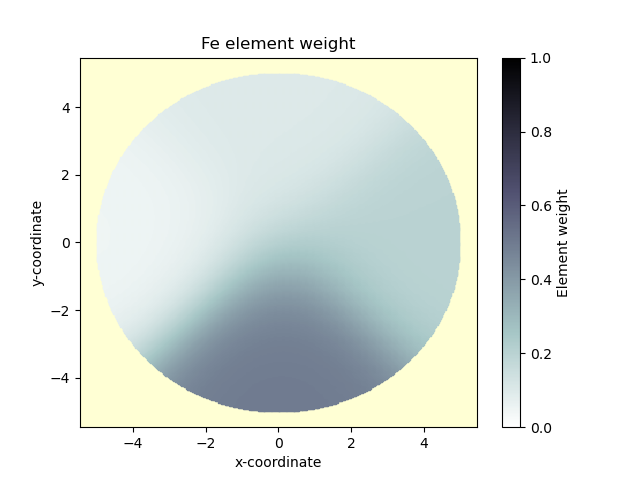

In [22]:
x_array = np.array(ds.x)
y_array = np.array(ds.y)
element_weights = np.array(ds.element_weights)
element_names = np.array(ds.elements)

marker = 's'
marker_size = 1
for i in range(element_weights.shape[1]):
    plt.figure()
    ax = plt.axes()
    ax.set_facecolor("xkcd:eggshell")
    plt.scatter(x_array, y_array, c=element_weights[:,i], cmap='bone_r', marker=marker, s=marker_size, vmin=0, vmax=1)
    plt.title(f"{element_names[0][i]} element weight")
    plt.colorbar(label='Element weight')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')



# Experiment class

In [24]:
class Experiment:
    def __init__(self, ground_truth):
        """ ground_truth is the netcdf file that gets loaded of the wafer, with a specific format """
        """ Has a dataset (knows everything) and a sample (knows only what has been measured) """

        self.ground_truth = ground_truth
        iq_shape = self.ground_truth['iq'].shape[1:]  # Extract the shape (tuple_index, q_points)

        # Initialize sample as an empty xarray Dataset with appropriate dimensions and coordinates
        # sample = the thing holding the data (iq) and metadata (x,y,xy) that gets measured


        self.sample = xr.Dataset(
            {
                'iq': (('index', 'tuple_index', 'q_points'), np.empty((0, *iq_shape))),
            },
            coords={
                'x': (('index',), []),
                'y': (('index',), []),
                'xy': (('index', 'coord'), np.empty((0, 2))),
            }
        )

    def _is_inside_convex_hull(self, x_coord, y_coord, coords):
        """ checks if points are inside the wafer """
        hull = ConvexHull(coords)  # can access vertices and simplices (edges) as attributes

        # here we check if inside using the winding number algorithm
        n = len(hull.vertices)
        winding_number = 0

        for i in range(n):
            x1, y1 = hull.points[hull.vertices[i]]
            x2, y2 = hull.points[hull.vertices[(i + 1) % n]]

            if y1 <= y_coord:
                if y2 > y_coord and (x2 - x1) * (y_coord - y1) - (x_coord - x1) * (y2 - y1) > 0:
                    winding_number += 1
            else:
                if y2 <= y_coord and (x2 - x1) * (y_coord - y1) - (x_coord - x1) * (y2 - y1) < 0:
                    winding_number -= 1

        return winding_number != 0

    def _get_value_at_coordinates(self, x_coord, y_coord, key, method='interpolate'):
        """ given x and y, return a tuple of numpy arrays (q, Iq) """

        if method == 'nearest':
            distances = np.sqrt((self.ground_truth['x'].values - x_coord)**2 + (self.ground_truth['y'].values - y_coord)**2)
            nearest_index = int(distances.argmin())
            nearest_value = self.ground_truth[key].isel(index=nearest_index).values
            return nearest_value
        elif method == 'interpolate':
            if self._is_inside_convex_hull(x_coord, y_coord, self.ground_truth['xy'].values):
                interpolated_value = griddata(points=(self.ground_truth['x'].values, self.ground_truth['y'].values),
                                              values=self.ground_truth[key].values,
                                              xi=(x_coord, y_coord),
                                              method='linear')
                return interpolated_value
            else:
                raise ValueError(f'xy position {x_coord, y_coord} outside bounds - enter coordinates within bounds')
        else:
            raise NameError(f"method not recognized - must be 'nearest' or 'interpolate' and input was {method}")

    def measure(self, x, y, method='interpolate', return_measured_data = False):
        """ collects data from coordinates (x,y), adds to 'sample' archive """
        iq_value = self._get_value_at_coordinates(x, y, key='iq', method=method)

        # Update sample dataset
        new_sample = xr.Dataset(
            {
                'iq': (('index', 'tuple_index', 'q_points'), [iq_value]),
            },
            coords={
                'x': (('index',), [x]),
                'y': (('index',), [y]),
                'xy': (('index', 'coord'), [(x, y)]),
            }
        )

        # Concatenate new sample to the existing sample dataset
        self.sample = xr.concat([self.sample, new_sample], dim='index')

        self.sample.attrs['num_measurements'] = self.sample.iq.shape[0]
        if return_measured_data:
            return iq_value


## Load wafer data as ground truth

In [25]:
# Load wafer data for experiment
path = '/nsls2/users/acorrao/MMM/DataSimulator'
file = 'ds_AlLiFe_7668-points.nc'
ground_truth = xr.open_dataset(os.path.join(path,file))
os.chdir(path) # moving into dir so that any files generated default to this dir

## Initialize experiment class with ground truth

In [26]:
# Initialize experiment class
experiment = Experiment(ground_truth)


## Do a measurement

In [27]:
experiment.measure(0,0)

## Look at measurement(s) stored in sample

In [28]:
experiment.sample

<xarray.Dataset> Size: 10kB
Dimensions:  (index: 1, tuple_index: 2, q_points: 650, coord: 2)
Coordinates:
    x        (index) float64 8B 0.0
    y        (index) float64 8B 0.0
    xy       (index, coord) float64 16B 0.0 0.0
Dimensions without coordinates: index, tuple_index, q_points, coord
Data variables:
    iq       (index, tuple_index, q_points) float64 10kB 15.0 15.1 ... 0.0002038
Attributes:
    num_measurements:  1

## Do many measurements

In [29]:
a = -3
b = 3
num_points = 20
xy_to_measure = [(np.random.uniform(a, b, 2)) for _ in range(num_points)]

In [30]:
for x, y in xy_to_measure:
    experiment.measure(x,y)

## Cluster on data collected

In [31]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(experiment.sample.iq[:,1])

KMeans(n_clusters=4, random_state=42)

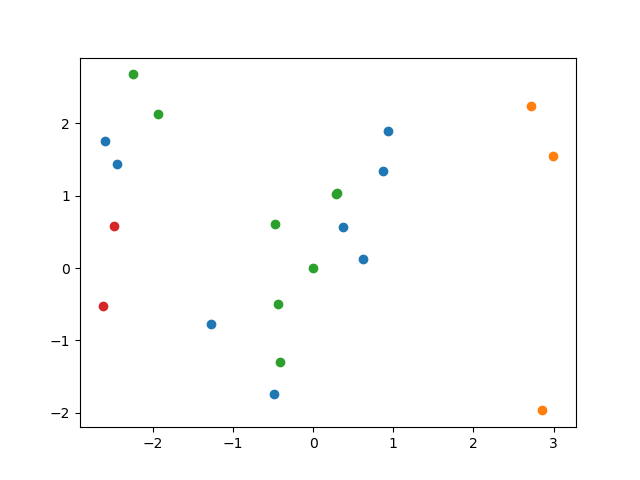

In [32]:
plt.figure()
for i in range(len(experiment.sample.x)):
    xis = experiment.sample.x[i].values
    yis = experiment.sample.y[i].values
    cis = 'C'+str(kmeans.labels_[i])
    plt.scatter(xis, yis, c=cis)